In [1]:
# import sys 
# sys.path
# sys.path.append("~/anaconda3/lib/python3.8/site-packages/tensorflow_estimator")
# sys.path
# import tensorflow as tf
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import keras
import tensorflow as tf
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 20 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 45 # the number of class
        self.feat_d = 190
        self.filters = 64
        self.data_dir = '/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/data/FPHAB/'
C = Config()

# Building the model

In [4]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize(x,size=[H,W]) 
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=20,joint_d=3,feat_d=190,filters=64):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)

In [5]:
def build_DD_Net(frame_l=32,joint_n=20,joint_d=3,feat_d=190,clc_num=45,filters=64):
    M = Input(name='M', shape=(frame_l,feat_d))   #32,231
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) #32,22,3
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters) #32,22,3,231,16
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [6]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_coarse,C.filters) #32,22,3,231,14,64

In [7]:
DD_Net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 190)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 20, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 512)       1733376     M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           model_1[1][0]              

## load data

In [8]:
Train = pickle.load(open(C.data_dir+"train_cs2.pkl", "rb"))
# print('Train',Train)
Test = pickle.load(open(C.data_dir+"test_cs2.pkl", "rb"))

## Without frame_sampling train

In [9]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,20,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['label'][i]-1] = 1  

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  #(1960,32,231) ndarray
X_1 = np.stack(X_1)  #(1960,32,22,3)
Y = np.stack(Y)

100%|████████████████████████████████████████| 985/985 [00:08<00:00, 122.31it/s]


In [10]:
# print(len(X_0))

In [11]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,20,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|████████████████████████████████████████| 190/190 [00:01<00:00, 128.10it/s]


In [12]:
# it may takes several times to reach the reported performance

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,  #history使得训练结果可视化
            batch_size=len(Y),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 985 samples, validate on 190 samples
Epoch 1/600
985/985 [==============================] - 6s 7ms/step - loss: 4.5220 - accuracy: 0.0213 - val_loss: 4.3876 - val_accuracy: 0.0211
Epoch 2/600
985/985 [==============================] - 0s 126us/step - loss: 4.2054 - accuracy: 0.0305 - val_loss: 4.6186 - val_accuracy: 0.0211
Epoch 3/600
985/985 [==============================] - 0s 150us/step - loss: 3.9907 - accuracy: 0.0487 - val_loss: 5.5205 - val_accuracy: 0.0211
Epoch 4/600
985/985 [==============================] - 0s 131us/step - loss: 3.7605 - accuracy: 0.0548 - val_loss: 7.2233 - val_accuracy: 0.0211
Epoch 5/600
985/985 [==============================] - 0s 128us/step - loss: 3.6893 - accuracy: 0.0944 - val_loss: 8.9570 - val_accuracy: 0.0211
Epoch 6/600
985/985 [==============================] - 0s 128us/step - loss: 3.5047 - accuracy: 0.1208 - val_loss: 9.8174 - val_accuracy: 0.0211
Epoch 7/600
985/985 [==============================] - 0s 133us/step - loss: 3.4048 - 

Epoch 57/600
985/985 [==============================] - 0s 137us/step - loss: 0.8179 - accuracy: 0.8518 - val_loss: 3.3078 - val_accuracy: 0.1684
Epoch 58/600
985/985 [==============================] - 0s 137us/step - loss: 0.8405 - accuracy: 0.8365 - val_loss: 3.2957 - val_accuracy: 0.1737
Epoch 59/600
985/985 [==============================] - 0s 140us/step - loss: 0.7902 - accuracy: 0.8599 - val_loss: 3.2608 - val_accuracy: 0.1947
Epoch 60/600
985/985 [==============================] - 0s 140us/step - loss: 0.7927 - accuracy: 0.8660 - val_loss: 3.2067 - val_accuracy: 0.1947
Epoch 61/600
985/985 [==============================] - 0s 134us/step - loss: 0.7641 - accuracy: 0.8629 - val_loss: 3.1693 - val_accuracy: 0.1895
Epoch 62/600
985/985 [==============================] - 0s 136us/step - loss: 0.7091 - accuracy: 0.8934 - val_loss: 3.1433 - val_accuracy: 0.1895
Epoch 63/600
985/985 [==============================] - 0s 138us/step - loss: 0.7240 - accuracy: 0.8751 - val_loss: 3.1016 -

985/985 [==============================] - 0s 138us/step - loss: 0.2148 - accuracy: 0.9817 - val_loss: 2.9960 - val_accuracy: 0.2474
Epoch 114/600
985/985 [==============================] - 0s 139us/step - loss: 0.2166 - accuracy: 0.9797 - val_loss: 2.9225 - val_accuracy: 0.2789
Epoch 115/600
985/985 [==============================] - 0s 144us/step - loss: 0.2194 - accuracy: 0.9787 - val_loss: 2.9032 - val_accuracy: 0.2842
Epoch 116/600
985/985 [==============================] - 0s 139us/step - loss: 0.2094 - accuracy: 0.9878 - val_loss: 2.8651 - val_accuracy: 0.3053
Epoch 117/600
985/985 [==============================] - 0s 140us/step - loss: 0.2142 - accuracy: 0.9817 - val_loss: 2.8930 - val_accuracy: 0.2895
Epoch 118/600
985/985 [==============================] - 0s 133us/step - loss: 0.1937 - accuracy: 0.9817 - val_loss: 2.9472 - val_accuracy: 0.2789
Epoch 119/600
985/985 [==============================] - 0s 142us/step - loss: 0.2009 - accuracy: 0.9766 - val_loss: 2.9896 - val_ac

Epoch 169/600
985/985 [==============================] - 0s 134us/step - loss: 0.1006 - accuracy: 0.9919 - val_loss: 2.2335 - val_accuracy: 0.4842
Epoch 170/600
985/985 [==============================] - 0s 136us/step - loss: 0.1036 - accuracy: 0.9929 - val_loss: 2.1730 - val_accuracy: 0.5000
Epoch 171/600
985/985 [==============================] - 0s 143us/step - loss: 0.1038 - accuracy: 0.9959 - val_loss: 2.1199 - val_accuracy: 0.5000
Epoch 172/600
985/985 [==============================] - 0s 135us/step - loss: 0.0972 - accuracy: 0.9929 - val_loss: 2.0826 - val_accuracy: 0.5158
Epoch 173/600
985/985 [==============================] - 0s 141us/step - loss: 0.1030 - accuracy: 0.9949 - val_loss: 2.0578 - val_accuracy: 0.5053
Epoch 174/600
985/985 [==============================] - 0s 135us/step - loss: 0.0961 - accuracy: 0.9929 - val_loss: 2.0407 - val_accuracy: 0.5211
Epoch 175/600
985/985 [==============================] - 0s 144us/step - loss: 0.0929 - accuracy: 0.9949 - val_loss: 2

Epoch 225/600
985/985 [==============================] - 0s 135us/step - loss: 0.0958 - accuracy: 0.9939 - val_loss: 1.5339 - val_accuracy: 0.6211
Epoch 226/600
985/985 [==============================] - 0s 142us/step - loss: 0.0941 - accuracy: 0.9970 - val_loss: 1.5237 - val_accuracy: 0.6263
Epoch 227/600
985/985 [==============================] - 0s 144us/step - loss: 0.0979 - accuracy: 0.9898 - val_loss: 1.5135 - val_accuracy: 0.6316
Epoch 228/600
985/985 [==============================] - 0s 137us/step - loss: 0.0943 - accuracy: 0.9949 - val_loss: 1.5032 - val_accuracy: 0.6316
Epoch 229/600
985/985 [==============================] - 0s 142us/step - loss: 0.0812 - accuracy: 0.9990 - val_loss: 1.4933 - val_accuracy: 0.6316
Epoch 230/600
985/985 [==============================] - 0s 138us/step - loss: 0.0911 - accuracy: 0.9949 - val_loss: 1.4836 - val_accuracy: 0.6316
Epoch 231/600
985/985 [==============================] - 0s 136us/step - loss: 0.0905 - accuracy: 0.9929 - val_loss: 1

Epoch 281/600
985/985 [==============================] - 0s 138us/step - loss: 0.0819 - accuracy: 0.9970 - val_loss: 1.0798 - val_accuracy: 0.7053
Epoch 282/600
985/985 [==============================] - 0s 135us/step - loss: 0.0877 - accuracy: 0.9970 - val_loss: 1.0736 - val_accuracy: 0.7053
Epoch 283/600
985/985 [==============================] - 0s 138us/step - loss: 0.0843 - accuracy: 0.9919 - val_loss: 1.0674 - val_accuracy: 0.7105
Epoch 284/600
985/985 [==============================] - 0s 143us/step - loss: 0.0895 - accuracy: 0.9909 - val_loss: 1.0614 - val_accuracy: 0.7105
Epoch 285/600
985/985 [==============================] - 0s 141us/step - loss: 0.0909 - accuracy: 0.9949 - val_loss: 1.0554 - val_accuracy: 0.7105
Epoch 286/600
985/985 [==============================] - 0s 137us/step - loss: 0.0891 - accuracy: 0.9939 - val_loss: 1.0498 - val_accuracy: 0.7158
Epoch 287/600
985/985 [==============================] - 0s 137us/step - loss: 0.0844 - accuracy: 0.9929 - val_loss: 1

Epoch 337/600
985/985 [==============================] - 0s 133us/step - loss: 0.1011 - accuracy: 0.9980 - val_loss: 0.8467 - val_accuracy: 0.7632
Epoch 338/600
985/985 [==============================] - 0s 137us/step - loss: 0.0824 - accuracy: 0.9949 - val_loss: 0.8439 - val_accuracy: 0.7632
Epoch 339/600
985/985 [==============================] - 0s 142us/step - loss: 0.0828 - accuracy: 0.9980 - val_loss: 0.8414 - val_accuracy: 0.7632
Epoch 340/600
985/985 [==============================] - 0s 140us/step - loss: 0.0944 - accuracy: 0.9959 - val_loss: 0.8390 - val_accuracy: 0.7632
Epoch 341/600
985/985 [==============================] - 0s 136us/step - loss: 0.0875 - accuracy: 0.9980 - val_loss: 0.8368 - val_accuracy: 0.7632
Epoch 342/600
985/985 [==============================] - 0s 140us/step - loss: 0.0830 - accuracy: 0.9980 - val_loss: 0.8344 - val_accuracy: 0.7684
Epoch 343/600
985/985 [==============================] - 0s 137us/step - loss: 0.0846 - accuracy: 0.9959 - val_loss: 0

Epoch 393/600
985/985 [==============================] - 0s 131us/step - loss: 0.1019 - accuracy: 0.9888 - val_loss: 0.7600 - val_accuracy: 0.7947
Epoch 394/600
985/985 [==============================] - 0s 124us/step - loss: 0.0855 - accuracy: 0.9949 - val_loss: 0.7591 - val_accuracy: 0.7947
Epoch 395/600
985/985 [==============================] - 0s 126us/step - loss: 0.0866 - accuracy: 0.9949 - val_loss: 0.7583 - val_accuracy: 0.7947
Epoch 396/600
985/985 [==============================] - 0s 127us/step - loss: 0.0858 - accuracy: 0.9990 - val_loss: 0.7575 - val_accuracy: 0.7947
Epoch 397/600
985/985 [==============================] - 0s 128us/step - loss: 0.0854 - accuracy: 0.9929 - val_loss: 0.7567 - val_accuracy: 0.7947
Epoch 398/600
985/985 [==============================] - 0s 134us/step - loss: 0.0905 - accuracy: 0.9959 - val_loss: 0.7559 - val_accuracy: 0.7947
Epoch 399/600
985/985 [==============================] - 0s 131us/step - loss: 0.0763 - accuracy: 1.0000 - val_loss: 0

Epoch 449/600
985/985 [==============================] - 0s 129us/step - loss: 0.0809 - accuracy: 0.9980 - val_loss: 0.7214 - val_accuracy: 0.7947
Epoch 450/600
985/985 [==============================] - 0s 129us/step - loss: 0.0851 - accuracy: 0.9959 - val_loss: 0.7207 - val_accuracy: 0.7947
Epoch 451/600
985/985 [==============================] - 0s 125us/step - loss: 0.0845 - accuracy: 0.9939 - val_loss: 0.7200 - val_accuracy: 0.7947
Epoch 452/600
985/985 [==============================] - 0s 136us/step - loss: 0.0809 - accuracy: 0.9980 - val_loss: 0.7194 - val_accuracy: 0.7947
Epoch 453/600
985/985 [==============================] - 0s 140us/step - loss: 0.0816 - accuracy: 0.9980 - val_loss: 0.7188 - val_accuracy: 0.7947
Epoch 454/600
985/985 [==============================] - 0s 141us/step - loss: 0.0885 - accuracy: 0.9970 - val_loss: 0.7183 - val_accuracy: 0.7947
Epoch 455/600
985/985 [==============================] - 0s 136us/step - loss: 0.0821 - accuracy: 0.9949 - val_loss: 0

Epoch 505/600
985/985 [==============================] - 0s 144us/step - loss: 0.0845 - accuracy: 0.9990 - val_loss: 0.7048 - val_accuracy: 0.7947
Epoch 506/600
985/985 [==============================] - 0s 143us/step - loss: 0.0904 - accuracy: 0.9949 - val_loss: 0.7045 - val_accuracy: 0.7947
Epoch 507/600
985/985 [==============================] - 0s 138us/step - loss: 0.0887 - accuracy: 0.9980 - val_loss: 0.7042 - val_accuracy: 0.7947
Epoch 508/600
985/985 [==============================] - 0s 172us/step - loss: 0.0746 - accuracy: 0.9970 - val_loss: 0.7039 - val_accuracy: 0.7947
Epoch 509/600
985/985 [==============================] - 0s 128us/step - loss: 0.0949 - accuracy: 0.9888 - val_loss: 0.7036 - val_accuracy: 0.7947
Epoch 510/600
985/985 [==============================] - 0s 124us/step - loss: 0.0872 - accuracy: 0.9980 - val_loss: 0.7033 - val_accuracy: 0.7947
Epoch 511/600
985/985 [==============================] - 0s 126us/step - loss: 0.0977 - accuracy: 0.9909 - val_loss: 0

Epoch 561/600
985/985 [==============================] - 0s 135us/step - loss: 0.0881 - accuracy: 0.9970 - val_loss: 0.7016 - val_accuracy: 0.7947
Epoch 562/600
985/985 [==============================] - 0s 130us/step - loss: 0.0817 - accuracy: 0.9939 - val_loss: 0.7018 - val_accuracy: 0.7947
Epoch 563/600
985/985 [==============================] - 0s 138us/step - loss: 0.0848 - accuracy: 0.9980 - val_loss: 0.7020 - val_accuracy: 0.7947
Epoch 564/600
985/985 [==============================] - 0s 131us/step - loss: 0.0880 - accuracy: 0.9929 - val_loss: 0.7023 - val_accuracy: 0.7947
Epoch 565/600
985/985 [==============================] - 0s 132us/step - loss: 0.0889 - accuracy: 0.9959 - val_loss: 0.7026 - val_accuracy: 0.7947
Epoch 566/600
985/985 [==============================] - 0s 144us/step - loss: 0.0848 - accuracy: 0.9959 - val_loss: 0.7029 - val_accuracy: 0.7947
Epoch 567/600
985/985 [==============================] - 0s 132us/step - loss: 0.0846 - accuracy: 0.9970 - val_loss: 0

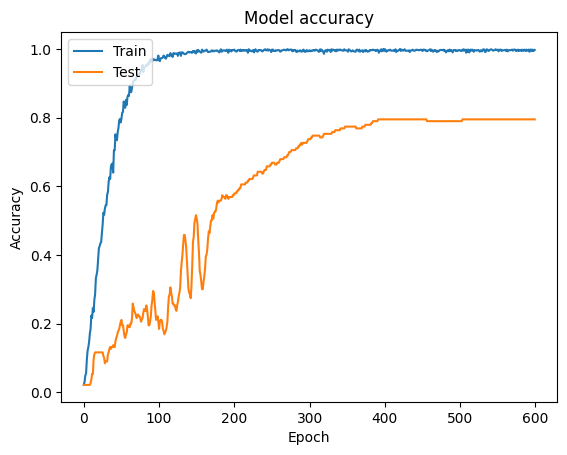

In [13]:
# Plot training & validation accuracy values
# plt.ylim(90,100)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig("/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/FPHAB/images/rlsherc_14_test1.png")
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
# DD_Net.save_weights('weights/coarse_heavy.h1')

In [15]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [16]:
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [17]:
from sklearn.metrics import accuracy_score
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.7947368421052632


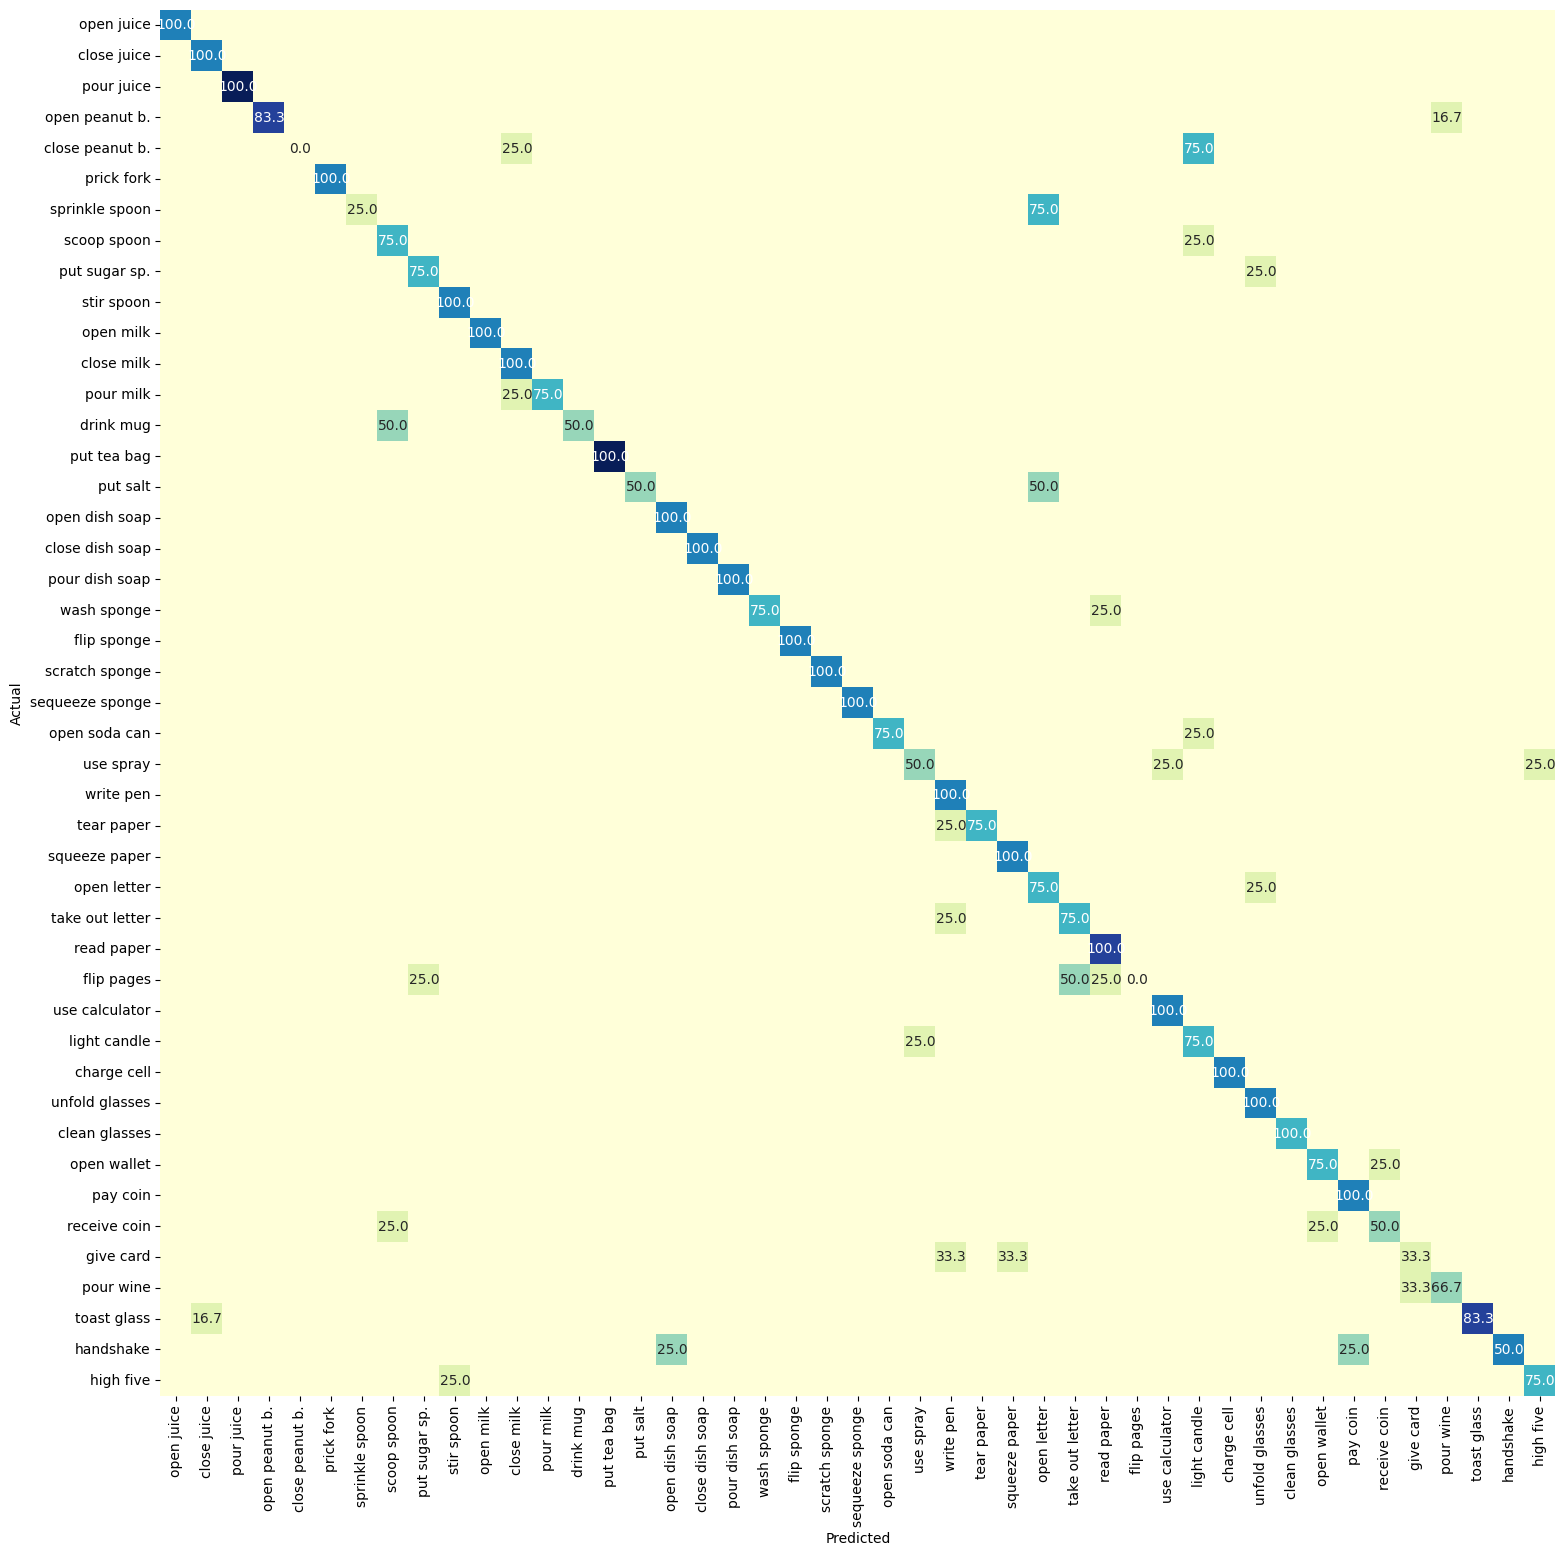

In [18]:
cm_analysis(y_true,y_pred, 'images/rlfhab_45_tes2.png', labels, ymap=None, figsize=(18,18))

## Training with frame_sampling

In [19]:
lr = 1e-5
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])

In [20]:
epochs = 20  #20
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 
    
        label = np.zeros(C.clc_coarse)
        label[Train['label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,20,3])
        p = sampling_frame(p,C)
       
        p = normlize_range(p)
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    DD_Net_model = DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

epoch0


100%|████████████████████████████████████████| 985/985 [00:08<00:00, 110.65it/s]


Train on 985 samples, validate on 190 samples
Epoch 1/1
985/985 [==============================] - 4s 4ms/step - loss: 0.1053 - accuracy: 0.9888 - val_loss: 0.7051 - val_accuracy: 0.7947
epoch1


100%|████████████████████████████████████████| 985/985 [00:08<00:00, 113.49it/s]


Train on 985 samples, validate on 190 samples
Epoch 1/1
985/985 [==============================] - 0s 136us/step - loss: 0.0815 - accuracy: 0.9959 - val_loss: 0.7052 - val_accuracy: 0.7895
epoch2


100%|████████████████████████████████████████| 985/985 [00:09<00:00, 109.37it/s]


Train on 985 samples, validate on 190 samples
Epoch 1/1
985/985 [==============================] - 0s 150us/step - loss: 0.0882 - accuracy: 0.9909 - val_loss: 0.7043 - val_accuracy: 0.7895
epoch3


100%|████████████████████████████████████████| 985/985 [00:08<00:00, 114.51it/s]


Train on 985 samples, validate on 190 samples
Epoch 1/1
985/985 [==============================] - 0s 133us/step - loss: 0.0854 - accuracy: 0.9980 - val_loss: 0.7037 - val_accuracy: 0.7947
epoch4


100%|████████████████████████████████████████| 985/985 [00:08<00:00, 112.78it/s]


Train on 985 samples, validate on 190 samples
Epoch 1/1
985/985 [==============================] - 0s 136us/step - loss: 0.1089 - accuracy: 0.9970 - val_loss: 0.7042 - val_accuracy: 0.7947
epoch5


100%|████████████████████████████████████████| 985/985 [00:08<00:00, 115.55it/s]


Train on 985 samples, validate on 190 samples
Epoch 1/1
985/985 [==============================] - 0s 138us/step - loss: 0.0961 - accuracy: 0.9970 - val_loss: 0.7041 - val_accuracy: 0.7947
epoch6


100%|████████████████████████████████████████| 985/985 [00:08<00:00, 117.68it/s]


Train on 985 samples, validate on 190 samples
Epoch 1/1
985/985 [==============================] - 0s 126us/step - loss: 0.0854 - accuracy: 0.9970 - val_loss: 0.7035 - val_accuracy: 0.7947
epoch7


100%|████████████████████████████████████████| 985/985 [00:08<00:00, 115.98it/s]


Train on 985 samples, validate on 190 samples
Epoch 1/1
985/985 [==============================] - 0s 135us/step - loss: 0.0842 - accuracy: 0.9970 - val_loss: 0.7028 - val_accuracy: 0.7947
epoch8


100%|████████████████████████████████████████| 985/985 [00:08<00:00, 116.18it/s]


Train on 985 samples, validate on 190 samples
Epoch 1/1
985/985 [==============================] - 0s 128us/step - loss: 0.0937 - accuracy: 0.9939 - val_loss: 0.7019 - val_accuracy: 0.7947
epoch9


100%|████████████████████████████████████████| 985/985 [00:08<00:00, 118.92it/s]


Train on 985 samples, validate on 190 samples
Epoch 1/1
985/985 [==============================] - 0s 125us/step - loss: 0.0972 - accuracy: 0.9939 - val_loss: 0.7014 - val_accuracy: 0.7947
epoch10


100%|████████████████████████████████████████| 985/985 [00:08<00:00, 118.82it/s]


Train on 985 samples, validate on 190 samples
Epoch 1/1
985/985 [==============================] - 0s 119us/step - loss: 0.1002 - accuracy: 0.9878 - val_loss: 0.7013 - val_accuracy: 0.7947
epoch11


100%|████████████████████████████████████████| 985/985 [00:08<00:00, 117.76it/s]


Train on 985 samples, validate on 190 samples
Epoch 1/1
985/985 [==============================] - 0s 118us/step - loss: 0.1007 - accuracy: 0.9919 - val_loss: 0.7006 - val_accuracy: 0.7947
epoch12


100%|████████████████████████████████████████| 985/985 [00:08<00:00, 120.41it/s]


Train on 985 samples, validate on 190 samples
Epoch 1/1
985/985 [==============================] - 0s 124us/step - loss: 0.0942 - accuracy: 0.9970 - val_loss: 0.7000 - val_accuracy: 0.7947
epoch13


100%|████████████████████████████████████████| 985/985 [00:08<00:00, 121.67it/s]


Train on 985 samples, validate on 190 samples
Epoch 1/1
985/985 [==============================] - 0s 126us/step - loss: 0.0789 - accuracy: 0.9959 - val_loss: 0.6994 - val_accuracy: 0.7947
epoch14


100%|████████████████████████████████████████| 985/985 [00:08<00:00, 118.28it/s]


Train on 985 samples, validate on 190 samples
Epoch 1/1
985/985 [==============================] - 0s 126us/step - loss: 0.1056 - accuracy: 0.9909 - val_loss: 0.6989 - val_accuracy: 0.7947
epoch15


100%|████████████████████████████████████████| 985/985 [00:08<00:00, 119.09it/s]


Train on 985 samples, validate on 190 samples
Epoch 1/1
985/985 [==============================] - 0s 126us/step - loss: 0.0916 - accuracy: 0.9970 - val_loss: 0.6985 - val_accuracy: 0.7947
epoch16


100%|████████████████████████████████████████| 985/985 [00:08<00:00, 121.74it/s]


Train on 985 samples, validate on 190 samples
Epoch 1/1
985/985 [==============================] - 0s 128us/step - loss: 0.0867 - accuracy: 0.9939 - val_loss: 0.6979 - val_accuracy: 0.8000
epoch17


100%|████████████████████████████████████████| 985/985 [00:08<00:00, 119.07it/s]


Train on 985 samples, validate on 190 samples
Epoch 1/1
985/985 [==============================] - 0s 133us/step - loss: 0.0938 - accuracy: 0.9939 - val_loss: 0.6969 - val_accuracy: 0.8000
epoch18


100%|████████████████████████████████████████| 985/985 [00:09<00:00, 107.79it/s]


Train on 985 samples, validate on 190 samples
Epoch 1/1
985/985 [==============================] - 0s 126us/step - loss: 0.0859 - accuracy: 0.9959 - val_loss: 0.6958 - val_accuracy: 0.8053
epoch19


100%|████████████████████████████████████████| 985/985 [00:08<00:00, 113.24it/s]


Train on 985 samples, validate on 190 samples
Epoch 1/1
985/985 [==============================] - 0s 122us/step - loss: 0.0978 - accuracy: 0.9919 - val_loss: 0.6946 - val_accuracy: 0.8053


# Plotting confusion matrix

In [21]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
# pickle.dump(DD_Net_model,open("/media/l/data/HRC/HRC_intention_recognition/code/DD-Net-master/SHREC/model/DD_Net.dat","wb"))  
# # 加载模型 
# loaded_model = pickle.load(open("/media/l/data/HRC/HRC_intention_recognition/code/DD-Net-master/SHREC/model/DD_Net.dat"","rb"))


In [22]:
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [23]:
from sklearn.metrics import accuracy_score
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.8052631578947368


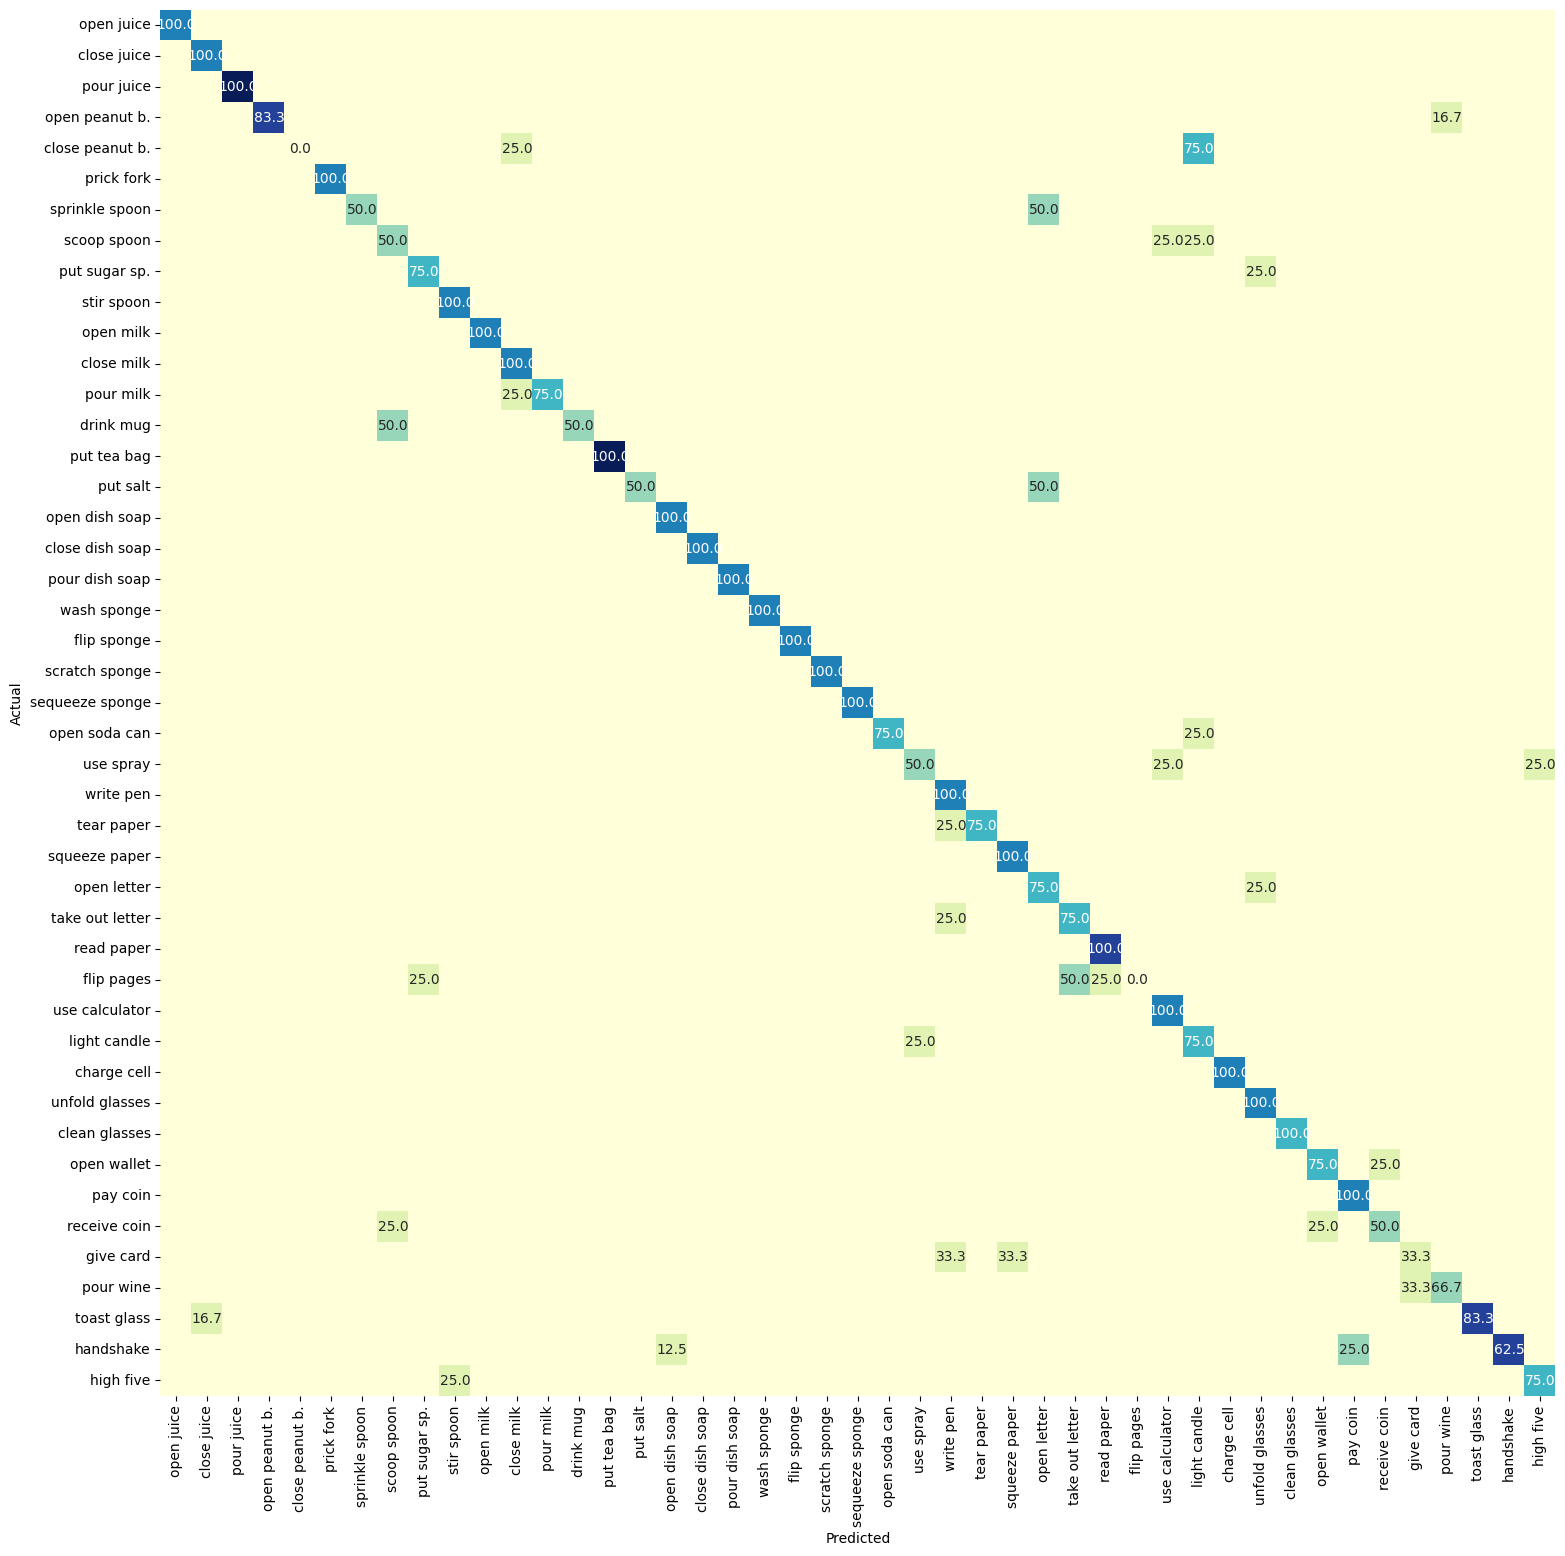

In [24]:
cm_analysis(y_true,y_pred, 'images/rlfphab_14_test3.png', labels, ymap=None, figsize=(18,18))

# Policy gradient for frame selection  -------train

In [25]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable #自动微分
from torch.nn import Linear,ReLU,CrossEntropyLoss,Sequential,Conv2d,MaxPool2d,Module,Softmax,BatchNorm2d,Dropout
from torch.optim import Adam,SGD

from numpy.random import default_rng
from utils import *

from numpy.random import default_rng


import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# import tqdm import tqdm

gamma = 0.7

#policy network with one hidden layer

class Policy(nn.Module):
    def __init__(self, n_states, n_actions, hidden_size, learning_rate=1e-4):
        super(Policy, self).__init__()

        self.n_actions = n_actions ##动作的数量

        self.cnn_layers = Sequential(Conv2d(1, 32, kernel_size=2),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(32, 64, kernel_size=3, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(64, 128, kernel_size=2, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),) #卷积网络

        self.linear_layers = Sequential(
            Linear(7680,3)) #32 8448  #7680
#         optimizer = Adam(model.parameters(), lr=0.001)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):  #CNN前向训练 第一次开始并没有Sb的信息
        x = x.float()
        x = self.cnn_layers(x)
        # x=x.size
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = F.softmax(x, dim=1)
        return x 
    
    def select_action(self, state):  #根据状态选择关键帧，输出关键帧
        # state = torch.from_numpy(state).float().unsqueeze(0)
        pr = self.forward(Variable(state))   #Variable进行自动微分；
        act = np.random.choice(self.n_actions, p=np.squeeze(pr.detach().numpy())) #状态输出
        log_pr = torch.log(pr.squeeze(0)[act]) #以e为底的对数函数   交叉熵损失公式11
        return act, log_pr
  
            
def update_policy(policy_network, rewards, log_probs): 
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        count = 0
        for r in rewards[t:]:
            Gt = Gt + gamma**count * r     #公式12
            count +=count
        discounted_rewards.append(Gt)
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-4) 
    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()


def calculate_reward(Probs, Probs_history , true_class): #计算奖励
  ## Probs is the outcome of softmax layer from classifier CNN # Probs : N_classes * 1
  ## Probs_history i the output of previous iteration
  ## true_class is an integer from [1-10]
  ## iteration is the number of iterations passed from the beginning
  omega = 3 # a measure of how strong are the punishments and stimulations
  predicted_class = np.argmax(Probs) + 1
  prev_predicted_class = np.argmax(Probs_history) + 1  ## +1 is bcz classes are from 1 to 10
  
  
  if (predicted_class == true_class and not(prev_predicted_class == true_class) ):
    reward = omega  ## stimulation
  elif ( not(predicted_class == true_class) and (prev_predicted_class == true_class) ):
    reward = - omega ## punishment
  else:
    true_class = int(true_class)
    reward = (np.sign(Probs[true_class - 1]  - Probs_history[true_class - 1])) ## -1 is bcz classes are from 1 to 10

  return reward   
# x_main=x_f  #x_f为全局帧

def train(oridata,labels): #x表示x_main，输入全局帧  label表示标签 
#     def train(x_m,x,oridata,labels): #x表示x_main，输入全局帧  label表示标签 
    n_states=32 #状态数量 这里应该指关键帧f的数量为30
    n_actions=3 #输出动作
    # env.seed(random_seed)
    policy_net = Policy(n_states, n_actions, 128) #策略选择网络 12
    max_episode_num =  10
    max_steps = 32  #最大跌打进行30?
#     numsteps = []
#     avg_numsteps = []
    all_rewards = []
#     x_trnew=[]
    label_new=[]
    final_ind=[]
    for episode in tqdm(range(max_episode_num)):        
        rewards2=[]
        x_tr=[]
        for v in tqdm(range(len(oridata))):
            log_probs = []
            rewards = []
#             x_tr_1=[]
            rng = default_rng()
            Action=[]
            if len(oridata[v])>=32:
                MM=np.sort(rng.choice(len(oridata[v]),size=32,replace=False))   
            else:
                MM=np.sort(rng.choice(len(oridata[v]),size=32,replace=True))  
            XX=oridata[v]  #输入数据
            original_fr=XX.clone().detach()  #clone()深拷贝 detach（） XX和original_fr具有相同的ID值
            original_label=labels[v].numpy()
            
            for steps in range(len(MM)):
#                 print('MM',MM)
#                 print('MM[steps]',MM[steps])
                state = original_fr[MM[steps]]
        #             print(state.shape)
                state = state.reshape(1, 1, 20, 3)
                state = torch.Tensor(state)
                action, log_prob = policy_net.select_action(state)
                Action.append(action)

                if action == 0 :
                    if steps == 0:
                        a = 0
                    else:
                        a = math.ceil(((MM[steps - 1]) + MM[steps]) / 2)
                    d = min(1, MM[steps] - a)
                    MM[steps] = MM[steps] - d
                if action == 1:
                    MM[steps] = MM[steps]
                if action == 2:
                    if steps == len(MM) - 1:
                        a = len(original_fr)
                    else:
                        a = math.ceil((MM[steps] + MM[steps + 1]) / 2)
                    d = min(1, a - MM[steps] - 1)
                    MM[steps] = MM[steps] + d

                xm1 = XX[MM]
                xmm = xm1

        #             q = xm1.
                q = np.array(xm1)
#              q = np.array(xm1).reshape([10,22,3])
        #             print(q.shape)
                q = zoom(q,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
        #             q = normlize_range(q)


                M = get_CG(q,C)  
                q = q.reshape(1,32,20,3)
                M = M.reshape(1,32,190)

                original_fr = XX
        #             with torch.no_grad():
                output = DD_Net.predict([M,q])       
                prob = output
                prediction = np.argmax(output,axis=1)

                prob=prob[0]
                if (steps == 0):
                  reward = 1 if prediction==original_label else -1     #公式9中的P，第一次迭代用来判断是否预测准确
                else:
                  reward=calculate_reward(prob, Probs_history ,original_label)
                Probs_history=prob #更新现在输出
                log_probs.append(log_prob)
                rewards.append(reward)
            
                if steps==len(MM) - 1:
                    xm1_step = XX[MM]
            x_tr.append(xm1_step)
            rewards2.append(np.mean(rewards))
            update_policy(policy_net, rewards, log_probs)    
            label_new.append(original_label)
#             print(x_tr)
        x_tr = torch.stack(x_tr)
#         print(x_tr)
#         print(x_tr.shape)
        
        if episode==max_episode_num-1:
          final_ind.append(Action)
            

        
        R=np.sum((rewards2))
#         x_trnew= torch.stack(x_trnew)
#         print('len(x_trnew)',len(x_trnew[0]))
        all_rewards.append(R)
 
    return all_rewards,x_tr,policy_net

/home/l/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
Train = pickle.load(open(C.data_dir+"train_cs2.pkl","rb"))

oridata = []

for i in tqdm(range(len(Train['pose']))):
    ori = np.copy(Train['pose'][i]).reshape([-1,20,3]) 
    ori = torch.tensor(ori)
    oridata.append(ori)
    
labels = [int(Train['label'][i]) for i in (range(len(Train['pose'])))]
labels = torch.Tensor(labels)
# print(X_3.shape)
# print(len(oridata))
# print(labels[1])
# print(type(labels))

100%|██████████████████████████████████████| 985/985 [00:00<00:00, 23922.21it/s]


In [27]:
all_rewards,x_trnew,policy_net=train(oridata,labels)
# all_rewards,x_tr,policy_net=train(X_2,X_3,oridata,labels)

 19%|███████▉                                 | 192/985 [02:13<09:09,  1.44it/s]


 39%|████████████████                         | 386/985 [04:26<06:42,  1.49it/s]


 59%|████████████████████████▏                | 580/985 [06:39<04:45,  1.42it/s]


 79%|████████████████████████████████▏        | 774/985 [08:53<02:22,  1.48it/s]


 98%|████████████████████████████████████████▎| 968/985 [11:07<00:11,  1.44it/s]


 18%|███████▎                                 | 175/985 [02:01<09:09,  1.47it/s]


 37%|███████████████▎                         | 369/985 [04:16<07:15,  1.41it/s]


 57%|███████████████████████▍                 | 563/985 [06:30<04:49,  1.46it/s]


 77%|███████████████████████████████▌         | 757/985 [08:43<02:38,  1.44it/s]


 97%|███████████████████████████████████████▌ | 951/985 [10:55<00:23,  1.47it/s]


 16%|██████▌                                  | 158/985 [01:49<09:29,  1.45it/s]


 36%|██████████████▋                          | 352/985 [04:05<07:24,  1.42it/s]


 55%|██████████████████████▋                  | 546/985 [06:19<05:02,  1.45it/s]


 75%|██████████████████████████████▊          | 740/985 [08:32<02:49,  1.45it/s]


 95%|██████████████████████████████████████▉  | 934/985 [10:44<00:33,  1.51it/s]


 14%|█████▊                                   | 141/985 [01:38<10:01,  1.40it/s]


 34%|█████████████▉                           | 335/985 [03:53<07:42,  1.41it/s]


 54%|██████████████████████                   | 529/985 [06:07<05:25,  1.40it/s]


 73%|██████████████████████████████           | 723/985 [08:21<03:05,  1.41it/s]


 93%|██████████████████████████████████████▏  | 917/985 [10:34<00:46,  1.46it/s]


 13%|█████▏                                   | 124/985 [01:25<10:04,  1.42it/s]


 32%|█████████████▏                           | 318/985 [03:41<07:48,  1.42it/s]


 52%|█████████████████████▎                   | 512/985 [05:56<05:29,  1.43it/s]


 72%|█████████████████████████████▍           | 706/985 [08:10<03:11,  1.46it/s]


 91%|█████████████████████████████████████▍   | 900/985 [10:23<00:57,  1.48it/s]


 11%|████▍                                    | 107/985 [01:14<10:17,  1.42it/s]


 31%|████████████▌                            | 301/985 [03:29<08:13,  1.39it/s]


 50%|████████████████████▌                    | 495/985 [05:43<05:36,  1.45it/s]


 70%|████████████████████████████▋            | 689/985 [07:56<03:22,  1.46it/s]


 90%|████████████████████████████████████▊    | 883/985 [10:08<01:09,  1.48it/s]


  9%|███▊                                      | 90/985 [01:03<10:47,  1.38it/s]


 29%|███████████▊                             | 284/985 [03:18<08:12,  1.42it/s]


 49%|███████████████████▉                     | 478/985 [05:33<05:56,  1.42it/s]


 68%|███████████████████████████▉             | 672/985 [07:47<03:31,  1.48it/s]


 88%|████████████████████████████████████     | 866/985 [10:01<01:21,  1.46it/s]


  7%|███                                       | 73/985 [00:50<10:23,  1.46it/s]


 27%|███████████                              | 267/985 [03:06<08:18,  1.44it/s]


 47%|███████████████████▏                     | 461/985 [05:22<06:01,  1.45it/s]


 66%|███████████████████████████▎             | 655/985 [07:36<03:45,  1.46it/s]


 86%|███████████████████████████████████▎     | 849/985 [09:50<01:32,  1.47it/s]


  6%|██▍                                       | 56/985 [00:38<10:37,  1.46it/s]


 25%|██████████▍                              | 250/985 [02:54<08:31,  1.44it/s]


 45%|██████████████████▍                      | 444/985 [05:09<06:22,  1.42it/s]


 65%|██████████████████████████▌              | 638/985 [07:22<03:56,  1.47it/s]


 84%|██████████████████████████████████▋      | 832/985 [09:36<01:47,  1.42it/s]


  4%|█▋                                        | 39/985 [00:27<10:35,  1.49it/s]


 24%|█████████▋                               | 233/985 [02:42<08:42,  1.44it/s]


 43%|█████████████████▊                       | 427/985 [04:58<06:29,  1.43it/s]


 63%|█████████████████████████▊               | 621/985 [07:13<04:13,  1.44it/s]


 83%|█████████████████████████████████▉       | 815/985 [09:27<01:57,  1.45it/s]


100%|████████████████████████████████████████| 10/10 [1:53:31<00:00, 681.14s/it]


In [28]:
# torch.save(policy_net.state_dict(),"model/policy_net.pth")
# import torch
# # from policy_net import *
 
# model = torch.load('model/policy_net.pth')
# print(model)

[-17.21875, -11.21875, -11.3125, -18.25, -20.0, -20.71875, -21.34375, -19.53125, -19.96875, -21.96875]


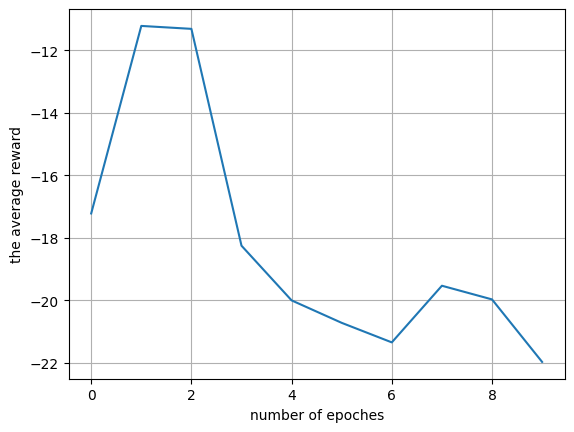

In [29]:
print(all_rewards)
plt.plot(all_rewards)
plt.xlabel('number of epoches')
plt.ylabel('the average reward')
plt.savefig("/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/FPHAB/images/RLsherc_14_reward.png")
plt.grid()

In [30]:
X_4 =[]
X_5 = []
labels_rl = []

for i in tqdm(range(len(x_trnew))):
    w_p = np.copy(x_trnew[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

100%|████████████████████████████████████████| 985/985 [00:08<00:00, 116.93it/s]


In [31]:
# it may takes several times to reach the reported performance

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  #history使得训练结果可视化
            batch_size=len(labels_rl),
            epochs=700, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 985 samples, validate on 190 samples
Epoch 1/700
985/985 [==============================] - 4s 4ms/step - loss: 0.1384 - accuracy: 0.9797 - val_loss: 1.1537 - val_accuracy: 0.6947
Epoch 2/700
985/985 [==============================] - 0s 110us/step - loss: 0.1745 - accuracy: 0.9695 - val_loss: 0.8969 - val_accuracy: 0.7579
Epoch 3/700
985/985 [==============================] - 0s 102us/step - loss: 0.1507 - accuracy: 0.9787 - val_loss: 0.9058 - val_accuracy: 0.7789
Epoch 4/700
985/985 [==============================] - 0s 92us/step - loss: 0.1957 - accuracy: 0.9665 - val_loss: 0.9486 - val_accuracy: 0.7789
Epoch 5/700
985/985 [==============================] - 0s 105us/step - loss: 0.1838 - accuracy: 0.9706 - val_loss: 1.0117 - val_accuracy: 0.7526
Epoch 6/700
985/985 [==============================] - 0s 96us/step - loss: 0.1731 - accuracy: 0.9746 - val_loss: 1.0657 - val_accuracy: 0.7368
Epoch 7/700
985/985 [==============================] - 0s 98us/step - loss: 0.1620 - acc

Epoch 58/700
985/985 [==============================] - 0s 95us/step - loss: 0.0766 - accuracy: 0.9919 - val_loss: 0.8264 - val_accuracy: 0.7789
Epoch 59/700
985/985 [==============================] - 0s 101us/step - loss: 0.0718 - accuracy: 0.9949 - val_loss: 0.8230 - val_accuracy: 0.7842
Epoch 60/700
985/985 [==============================] - 0s 89us/step - loss: 0.0709 - accuracy: 0.9980 - val_loss: 0.8185 - val_accuracy: 0.7789
Epoch 61/700
985/985 [==============================] - 0s 98us/step - loss: 0.0718 - accuracy: 0.9919 - val_loss: 0.8160 - val_accuracy: 0.7789
Epoch 62/700
985/985 [==============================] - 0s 95us/step - loss: 0.0712 - accuracy: 0.9909 - val_loss: 0.8138 - val_accuracy: 0.7789
Epoch 63/700
985/985 [==============================] - 0s 103us/step - loss: 0.0660 - accuracy: 0.9959 - val_loss: 0.8127 - val_accuracy: 0.7842
Epoch 64/700
985/985 [==============================] - 0s 87us/step - loss: 0.0662 - accuracy: 0.9959 - val_loss: 0.8112 - val_

Epoch 115/700
985/985 [==============================] - 0s 104us/step - loss: 0.0653 - accuracy: 0.9949 - val_loss: 0.7889 - val_accuracy: 0.8053
Epoch 116/700
985/985 [==============================] - 0s 96us/step - loss: 0.0638 - accuracy: 0.9970 - val_loss: 0.7882 - val_accuracy: 0.8053
Epoch 117/700
985/985 [==============================] - 0s 97us/step - loss: 0.0532 - accuracy: 1.0000 - val_loss: 0.7874 - val_accuracy: 0.8053
Epoch 118/700
985/985 [==============================] - 0s 96us/step - loss: 0.0571 - accuracy: 1.0000 - val_loss: 0.7866 - val_accuracy: 0.8053
Epoch 119/700
985/985 [==============================] - 0s 101us/step - loss: 0.0538 - accuracy: 0.9990 - val_loss: 0.7860 - val_accuracy: 0.8053
Epoch 120/700
985/985 [==============================] - 0s 93us/step - loss: 0.0583 - accuracy: 0.9970 - val_loss: 0.7854 - val_accuracy: 0.8053
Epoch 121/700
985/985 [==============================] - 0s 107us/step - loss: 0.0617 - accuracy: 0.9980 - val_loss: 0.784

Epoch 171/700
985/985 [==============================] - 0s 104us/step - loss: 0.0558 - accuracy: 0.9990 - val_loss: 0.7684 - val_accuracy: 0.8053
Epoch 172/700
985/985 [==============================] - 0s 97us/step - loss: 0.0639 - accuracy: 0.9939 - val_loss: 0.7682 - val_accuracy: 0.8053
Epoch 173/700
985/985 [==============================] - 0s 104us/step - loss: 0.0621 - accuracy: 0.9949 - val_loss: 0.7680 - val_accuracy: 0.8053
Epoch 174/700
985/985 [==============================] - 0s 96us/step - loss: 0.0622 - accuracy: 0.9959 - val_loss: 0.7677 - val_accuracy: 0.8053
Epoch 175/700
985/985 [==============================] - 0s 121us/step - loss: 0.0648 - accuracy: 0.9919 - val_loss: 0.7671 - val_accuracy: 0.8053
Epoch 176/700
985/985 [==============================] - 0s 98us/step - loss: 0.0547 - accuracy: 0.9970 - val_loss: 0.7666 - val_accuracy: 0.8053
Epoch 177/700
985/985 [==============================] - 0s 106us/step - loss: 0.0549 - accuracy: 0.9949 - val_loss: 0.76

Epoch 227/700
985/985 [==============================] - 0s 104us/step - loss: 0.0652 - accuracy: 0.9929 - val_loss: 0.7518 - val_accuracy: 0.8158
Epoch 228/700
985/985 [==============================] - 0s 106us/step - loss: 0.0544 - accuracy: 0.9949 - val_loss: 0.7519 - val_accuracy: 0.8158
Epoch 229/700
985/985 [==============================] - 0s 105us/step - loss: 0.0657 - accuracy: 0.9949 - val_loss: 0.7521 - val_accuracy: 0.8158
Epoch 230/700
985/985 [==============================] - 0s 100us/step - loss: 0.0745 - accuracy: 0.9970 - val_loss: 0.7522 - val_accuracy: 0.8158
Epoch 231/700
985/985 [==============================] - 0s 106us/step - loss: 0.0593 - accuracy: 0.9990 - val_loss: 0.7522 - val_accuracy: 0.8158
Epoch 232/700
985/985 [==============================] - 0s 96us/step - loss: 0.0620 - accuracy: 0.9980 - val_loss: 0.7521 - val_accuracy: 0.8158
Epoch 233/700
985/985 [==============================] - 0s 107us/step - loss: 0.0658 - accuracy: 0.9929 - val_loss: 0.

Epoch 283/700
985/985 [==============================] - 0s 104us/step - loss: 0.0549 - accuracy: 0.9949 - val_loss: 0.7543 - val_accuracy: 0.8211
Epoch 284/700
985/985 [==============================] - 0s 109us/step - loss: 0.0636 - accuracy: 0.9949 - val_loss: 0.7543 - val_accuracy: 0.8211
Epoch 285/700
985/985 [==============================] - 0s 106us/step - loss: 0.0545 - accuracy: 0.9970 - val_loss: 0.7544 - val_accuracy: 0.8211
Epoch 286/700
985/985 [==============================] - 0s 96us/step - loss: 0.0599 - accuracy: 0.9980 - val_loss: 0.7544 - val_accuracy: 0.8211
Epoch 287/700
985/985 [==============================] - 0s 102us/step - loss: 0.0493 - accuracy: 1.0000 - val_loss: 0.7544 - val_accuracy: 0.8211
Epoch 288/700
985/985 [==============================] - 0s 100us/step - loss: 0.0638 - accuracy: 0.9970 - val_loss: 0.7544 - val_accuracy: 0.8211
Epoch 289/700
985/985 [==============================] - 0s 100us/step - loss: 0.0552 - accuracy: 0.9959 - val_loss: 0.

Epoch 339/700
985/985 [==============================] - 0s 107us/step - loss: 0.0580 - accuracy: 0.9990 - val_loss: 0.7565 - val_accuracy: 0.8158
Epoch 340/700
985/985 [==============================] - 0s 96us/step - loss: 0.0576 - accuracy: 0.9959 - val_loss: 0.7566 - val_accuracy: 0.8158
Epoch 341/700
985/985 [==============================] - 0s 108us/step - loss: 0.0576 - accuracy: 0.9959 - val_loss: 0.7567 - val_accuracy: 0.8158
Epoch 342/700
985/985 [==============================] - 0s 99us/step - loss: 0.0605 - accuracy: 0.9929 - val_loss: 0.7568 - val_accuracy: 0.8211
Epoch 343/700
985/985 [==============================] - 0s 101us/step - loss: 0.0612 - accuracy: 0.9970 - val_loss: 0.7569 - val_accuracy: 0.8211
Epoch 344/700
985/985 [==============================] - 0s 96us/step - loss: 0.0671 - accuracy: 0.9939 - val_loss: 0.7569 - val_accuracy: 0.8211
Epoch 345/700
985/985 [==============================] - 0s 104us/step - loss: 0.0489 - accuracy: 0.9990 - val_loss: 0.75

Epoch 395/700
985/985 [==============================] - 0s 103us/step - loss: 0.0565 - accuracy: 0.9970 - val_loss: 0.7597 - val_accuracy: 0.8158
Epoch 396/700
985/985 [==============================] - 0s 98us/step - loss: 0.0605 - accuracy: 0.9959 - val_loss: 0.7597 - val_accuracy: 0.8158
Epoch 397/700
985/985 [==============================] - 0s 102us/step - loss: 0.0607 - accuracy: 0.9959 - val_loss: 0.7598 - val_accuracy: 0.8158
Epoch 398/700
985/985 [==============================] - 0s 98us/step - loss: 0.0643 - accuracy: 0.9970 - val_loss: 0.7597 - val_accuracy: 0.8158
Epoch 399/700
985/985 [==============================] - 0s 106us/step - loss: 0.0597 - accuracy: 0.9970 - val_loss: 0.7594 - val_accuracy: 0.8158
Epoch 400/700
985/985 [==============================] - 0s 99us/step - loss: 0.0630 - accuracy: 0.9970 - val_loss: 0.7591 - val_accuracy: 0.8158
Epoch 401/700
985/985 [==============================] - 0s 105us/step - loss: 0.0574 - accuracy: 0.9970 - val_loss: 0.75

Epoch 451/700
985/985 [==============================] - 0s 103us/step - loss: 0.0611 - accuracy: 0.9970 - val_loss: 0.7507 - val_accuracy: 0.8211
Epoch 452/700
985/985 [==============================] - 0s 99us/step - loss: 0.0576 - accuracy: 0.9970 - val_loss: 0.7507 - val_accuracy: 0.8211
Epoch 453/700
985/985 [==============================] - 0s 109us/step - loss: 0.0550 - accuracy: 0.9980 - val_loss: 0.7507 - val_accuracy: 0.8211
Epoch 454/700
985/985 [==============================] - 0s 98us/step - loss: 0.0646 - accuracy: 0.9949 - val_loss: 0.7508 - val_accuracy: 0.8211
Epoch 455/700
985/985 [==============================] - 0s 105us/step - loss: 0.0589 - accuracy: 0.9980 - val_loss: 0.7509 - val_accuracy: 0.8211
Epoch 456/700
985/985 [==============================] - 0s 100us/step - loss: 0.0645 - accuracy: 0.9949 - val_loss: 0.7510 - val_accuracy: 0.8211
Epoch 457/700
985/985 [==============================] - 0s 103us/step - loss: 0.0601 - accuracy: 1.0000 - val_loss: 0.7

Epoch 507/700
985/985 [==============================] - 0s 107us/step - loss: 0.0574 - accuracy: 0.9980 - val_loss: 0.7585 - val_accuracy: 0.8158
Epoch 508/700
985/985 [==============================] - 0s 96us/step - loss: 0.0502 - accuracy: 0.9970 - val_loss: 0.7588 - val_accuracy: 0.8158
Epoch 509/700
985/985 [==============================] - 0s 102us/step - loss: 0.0557 - accuracy: 0.9980 - val_loss: 0.7588 - val_accuracy: 0.8158
Epoch 510/700
985/985 [==============================] - 0s 100us/step - loss: 0.0466 - accuracy: 0.9990 - val_loss: 0.7587 - val_accuracy: 0.8158
Epoch 511/700
985/985 [==============================] - 0s 104us/step - loss: 0.0539 - accuracy: 0.9980 - val_loss: 0.7587 - val_accuracy: 0.8158
Epoch 512/700
985/985 [==============================] - 0s 99us/step - loss: 0.0483 - accuracy: 0.9980 - val_loss: 0.7586 - val_accuracy: 0.8105
Epoch 513/700
985/985 [==============================] - 0s 102us/step - loss: 0.0574 - accuracy: 0.9970 - val_loss: 0.7

Epoch 563/700
985/985 [==============================] - 0s 107us/step - loss: 0.0601 - accuracy: 0.9970 - val_loss: 0.7636 - val_accuracy: 0.8211
Epoch 564/700
985/985 [==============================] - 0s 100us/step - loss: 0.0528 - accuracy: 0.9980 - val_loss: 0.7637 - val_accuracy: 0.8211
Epoch 565/700
985/985 [==============================] - 0s 105us/step - loss: 0.0673 - accuracy: 0.9949 - val_loss: 0.7641 - val_accuracy: 0.8211
Epoch 566/700
985/985 [==============================] - 0s 99us/step - loss: 0.0527 - accuracy: 0.9959 - val_loss: 0.7644 - val_accuracy: 0.8211
Epoch 567/700
985/985 [==============================] - 0s 106us/step - loss: 0.0553 - accuracy: 0.9959 - val_loss: 0.7645 - val_accuracy: 0.8211
Epoch 568/700
985/985 [==============================] - 0s 99us/step - loss: 0.0671 - accuracy: 0.9939 - val_loss: 0.7646 - val_accuracy: 0.8211
Epoch 569/700
985/985 [==============================] - 0s 106us/step - loss: 0.0551 - accuracy: 0.9970 - val_loss: 0.7

Epoch 619/700
985/985 [==============================] - 0s 106us/step - loss: 0.0596 - accuracy: 0.9949 - val_loss: 0.7657 - val_accuracy: 0.8105
Epoch 620/700
985/985 [==============================] - 0s 99us/step - loss: 0.0614 - accuracy: 0.9949 - val_loss: 0.7657 - val_accuracy: 0.8105
Epoch 621/700
985/985 [==============================] - 0s 104us/step - loss: 0.0615 - accuracy: 0.9980 - val_loss: 0.7658 - val_accuracy: 0.8105
Epoch 622/700
985/985 [==============================] - 0s 100us/step - loss: 0.0646 - accuracy: 0.9929 - val_loss: 0.7658 - val_accuracy: 0.8105
Epoch 623/700
985/985 [==============================] - 0s 102us/step - loss: 0.0513 - accuracy: 0.9970 - val_loss: 0.7659 - val_accuracy: 0.8105
Epoch 624/700
985/985 [==============================] - 0s 102us/step - loss: 0.0563 - accuracy: 0.9980 - val_loss: 0.7659 - val_accuracy: 0.8105
Epoch 625/700
985/985 [==============================] - 0s 104us/step - loss: 0.0452 - accuracy: 1.0000 - val_loss: 0.

Epoch 675/700
985/985 [==============================] - 0s 106us/step - loss: 0.0542 - accuracy: 0.9970 - val_loss: 0.7607 - val_accuracy: 0.8105
Epoch 676/700
985/985 [==============================] - 0s 94us/step - loss: 0.0639 - accuracy: 0.9939 - val_loss: 0.7605 - val_accuracy: 0.8105
Epoch 677/700
985/985 [==============================] - 0s 103us/step - loss: 0.0601 - accuracy: 0.9959 - val_loss: 0.7601 - val_accuracy: 0.8105
Epoch 678/700
985/985 [==============================] - 0s 98us/step - loss: 0.0447 - accuracy: 0.9990 - val_loss: 0.7596 - val_accuracy: 0.8105
Epoch 679/700
985/985 [==============================] - 0s 105us/step - loss: 0.0512 - accuracy: 0.9980 - val_loss: 0.7593 - val_accuracy: 0.8105
Epoch 680/700
985/985 [==============================] - 0s 101us/step - loss: 0.0524 - accuracy: 0.9970 - val_loss: 0.7587 - val_accuracy: 0.8105
Epoch 681/700
985/985 [==============================] - 0s 107us/step - loss: 0.0609 - accuracy: 0.9929 - val_loss: 0.7

In [32]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [33]:
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [34]:
#from sklearn.metrics import accuracy_score
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.8157894736842105


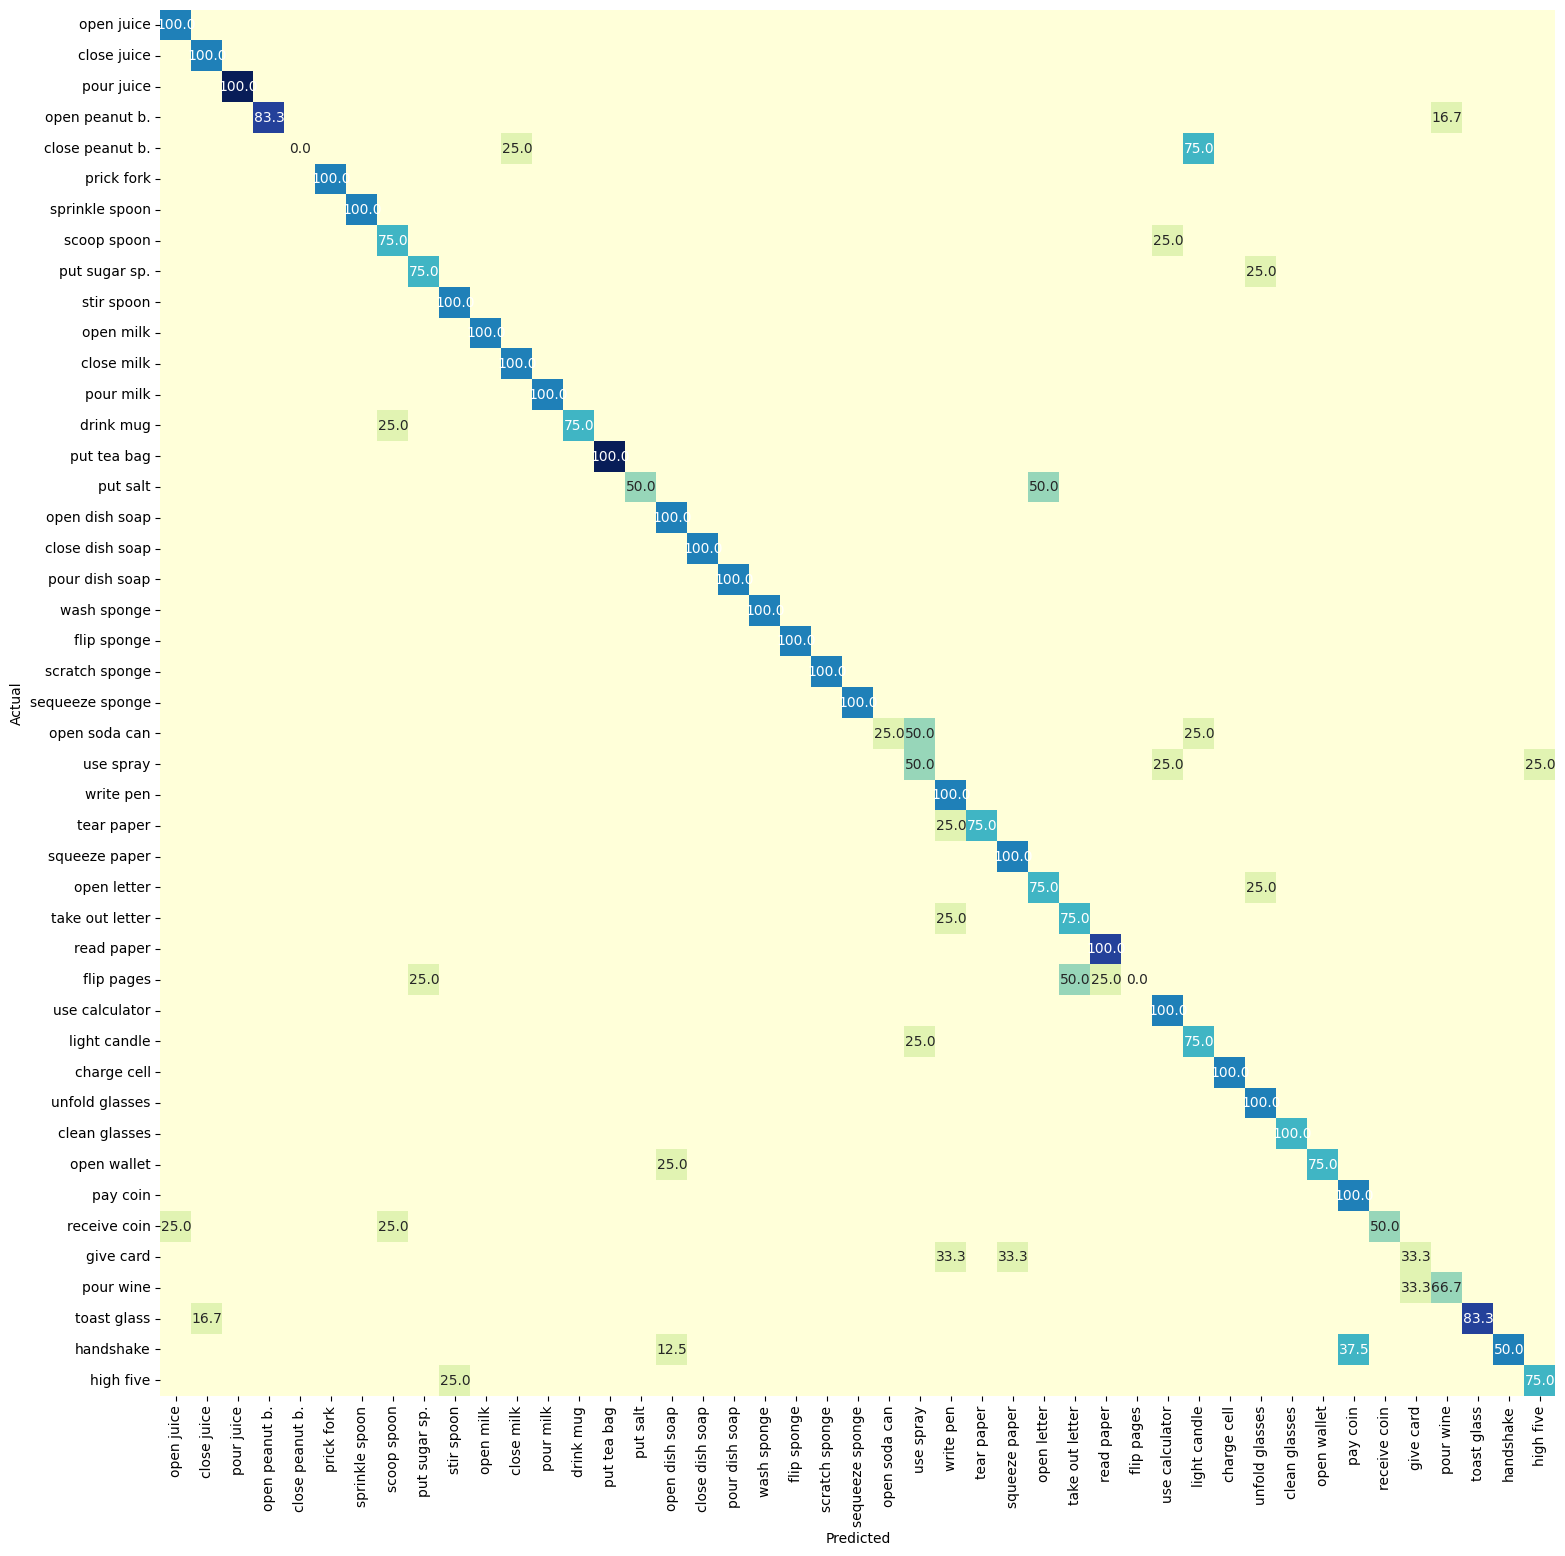

In [35]:
cm_analysis(y_true,y_pred, 'images/rlSHREC_14_test2.png', labels, ymap=None, figsize=(18,18))

### test accuracy   -through RL get test data

In [36]:
Test = pickle.load(open(C.data_dir+"test_cs2.pkl","rb"))

X_test_2 = []
X_test_3 = []
labels_test = []
for i in tqdm(range(len(Test['pose']))): 
    test_or_p = np.copy(Test['pose'][i]).reshape([-1,20,3])
    test_or_p = zoom(test_or_p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    test_or_p = normlize_range(test_or_p)
    label = np.zeros(C.clc_coarse)
    label[Test['label'][i]-1] = 1   
    
    M = get_CG(p,C)
       
    p = torch.tensor(p)
    M = torch.tensor(M)

    X_test_2.append(M)
    X_test_3.append(p)
    labels_test.append(label)

X_test_2 = np.stack(X_test_0) 
X_test_3 = np.stack(X_test_1)  
labels_test  = np.stack(labels_test)


100%|████████████████████████████████████████| 190/190 [00:01<00:00, 108.67it/s]


In [38]:

def test(X_TEST): #x表示x_main，输入全局帧  label表示标签 
#     def train(x_m,x,oridata,labels): #x表示x_main，输入全局帧  label表示标签 
    n_states=20 #状态数量 这里应该指关键帧f的数量为30
    n_actions=3 #输出动作
    # env.seed(random_seed)
#     policy_net = Policy(n_states, n_actions, 128) #策略选择网络 12
#     Policy  = torch.load('model/policy_net.pth')
    policy_net = Policy(n_states, n_actions, 128) #策略选择网络 12
    max_steps = 32  #最大
    XM=[]
    for v in tqdm(range(len(X_TEST))):
        log_probs = []
        rewards = []
        Action=[]
        if len(oridata[v])>=32:
            rng = default_rng()
            MM=np.sort(rng.choice(len(X_TEST[v]),size=32,replace=False))   
        else:
            MM=np.sort(rng.choice(len(X_TEST[v]),size=32,replace=True))  
        XX=X_TEST[v]  #输入数据
        for steps in range(len(MM)):
            state = XX[MM[steps]]
            state = state.reshape(1, 1, 20, 3)
            state = torch.Tensor(state)
            action, log_prob = policy_net.select_action(state)
#             action, log_prob = policy_net(state)
            Action.append(action)

            if action == 0 :
                if steps == 0:
                    a = 0
                else:
                    a = math.ceil(((MM[steps - 1]) + MM[steps]) / 2)
                d = min(1, MM[steps] - a)
                MM[steps] = MM[steps] - d
            if action == 1:
                MM[steps] = MM[steps]
            if action == 2:
                if steps == len(MM) - 1:
                    a = len(XX)
                else:
                    a = math.ceil((MM[steps] + MM[steps + 1]) / 2)
                d = min(1, a - MM[steps] - 1)
                MM[steps] = MM[steps] + d
        xm1 = XX[MM]
        XM.append(xm1)
                      
    return XM
    
XM = test(X_test_1)

100%|█████████████████████████████████████████| 190/190 [00:08<00:00, 21.62it/s]


In [39]:
test_0 =[]
test_1 = []


for i in tqdm(range(len(XM))):
    test_p = np.copy(XM[i]).reshape([-1,20,3]) 
    test_p = np.array(test_p)
    test_p = zoom(test_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    test_p = normlize_range(test_p)

    test_M = get_CG(test_p,C)

    test_0.append(test_M)
    test_1.append(test_p)

test_0 = np.stack(test_0)
test_1 = np.stack(test_1)


100%|████████████████████████████████████████| 190/190 [00:01<00:00, 127.70it/s]


In [ ]:

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  #history使得训练结果可视化
            batch_size=len(Y),
            epochs=700, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([test_0,test_1],labels_test)      
            )

In [30]:
DD_Net.save_weights('weights/coarse_heavy.h2')

In [40]:
Y_pred_rltest = DD_Net.predict([test_0,test_1])

In [41]:
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred_test = []
for i in np.argmax(Y_pred_rltest,axis=1):
    y_pred_test.append(labels[i])

In [42]:
#from sklearn.metrics import accuracy_score
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.8157894736842105


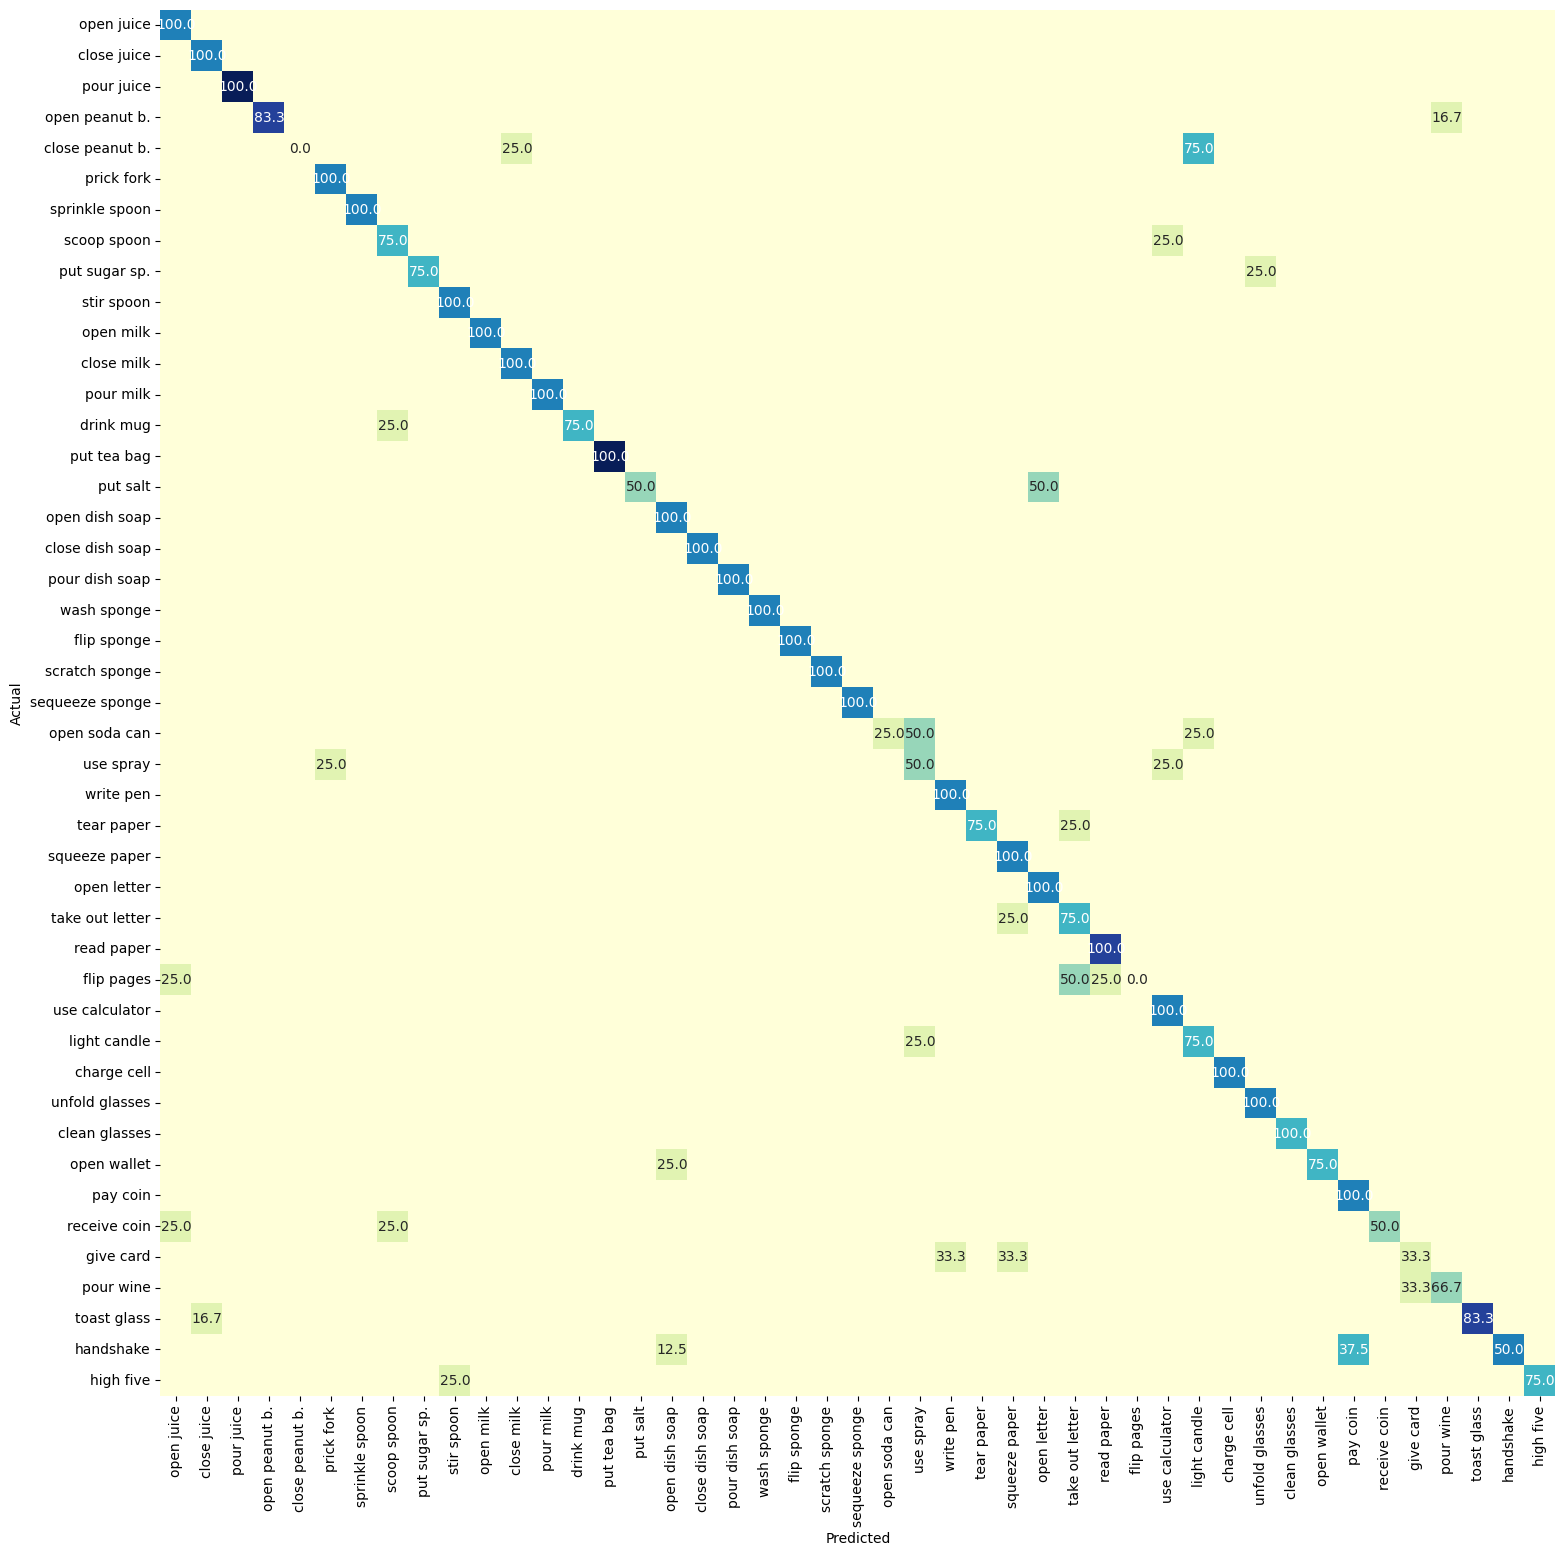

In [43]:
cm_analysis(y_true,y_pred_test, 'images/rlSHREC_14_test5.png', labels, ymap=None, figsize=(18,18))